# Reconstructing Light-Curves

This notebook uses observations from CSP DR3 to explore the use of interpolation to supliment light-curve fits.

#### Table of Contents:
1. <a href='#setup'>Setup</a>: Downloads the CSP DR3 data set and registers the CSP filters with SNCosmo
1. <a href='#regression_vs_modeling'>Regression vs Modeling</a>: Compares fits to light-curve data using Salt2.4 and a Gaussian regression
1. <a href='#deconstructing'>Deconstructing and Reconstructing Light-Curves</a>: We remove every `n` points from a light-curve, and then try to re-create the missing data using interpolation and regression.



In [1]:
import sys

import numpy as np
import sncosmo
import sndata
from IPython.display import clear_output
from astropy.table import Column, vstack
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from sndata.csp import dr3

sys.path.insert(0, '../')
import lc_regression
from lc_regression import utils


## Setup <a id='setup'></a>

This notebook relies on the CSP DR3 data set. We start by downloading the data release and registering the CSP filters with the `sncosmo` package. We also instantiate a Salt2 model for use later on.

In [2]:
dr3.download_module_data()
dr3.register_filters(force=True)

# Register filters with sncosmo
dr3.download_module_data()
dr3.register_filters(force=True)

# A Salt2.4 model
salt2 = sncosmo.Model(sncosmo.get_source('salt2', version='2.4'))

print('The DR3 data set:')
dr3.load_table(1).to_pandas().head(10)

The DR3 data set:


,SN,RAh,RAm,RAs,DE-,DEd,DEm,DEs,Host,n_Host,Morph,z,n_z,DiscRef,DiscGroup
0,2004dt,2,2,12.77,-,0,5,51.5,NGC 799,NaN,(R')SB(s)a,0.0197,NaN,IAUC 8386,LOSS
1,2004ef,22,42,10.02,+,19,59,40.4,UGC 12158,NaN,Sb,0.0310,NaN,IAUC 8399,Boles/Armstrong
2,2004eo,20,32,54.19,+,9,55,42.7,NGC 6928,NaN,SB(s)ab,0.0157,NaN,IAUC 8406,Itagaki
3,2004ey,21,49,7.81,+,0,26,39.2,UGC 11816,NaN,SB(rs)c,0.0158,NaN,IAUC 8419,Tenagra-II
4,2004gc,5,21,49.95,+,6,40,33.7,ARP 327 NED04,NaN,---,0.0321,NaN,IAUC 8442,del Olmo/Tenagra-II
5,2004gs,8,38,23.18,+,17,37,39.8,MCG +03-22-020,NaN,S0?,0.0267,NaN,IAUC 8453,LOSS
6,2004gu,12,46,24.72,+,11,56,56.1,FGC 175A,NaN,---,0.0459,NaN,IAUC 8454,ROTSE-III
7,2005A,2,30,43.25,-,2,56,19.8,NGC 958,NaN,SB(rs)c,0.0191,NaN,IAUC 8459,LOSS
8,2005M,9,37,32.36,+,23,12,2.7,NGC 2930,NaN,S?,0.0220,NaN,IAUC 8470,Puckett
9,2005W,1,50,45.77,+,21,45,35.4,NGC 691,NaN,SA(rs)bc,0.0089,NaN,IAUC 8475,Hirose


## Regression vs Modeling <a id='regression_vs_modeling'></a>

We fit a CSP light-curve using both a Gaussian regression and the Salt2.4 model. Plotting the two allows us to visually build an intuition for the behavior of both approaches.

In [3]:
def create_empty_figure(bands):
    """Create an empty figure to plot light-curves on
    
    Args:
        bands (list): A list of band names
    
    Returns:
        The figure object
        An array of figure axes
    """
    
    columns = 2
    rows = int(np.ceil(len(bands) / 2))
    fig_shape = (rows, columns)
    fig_size = (3 * rows, 6 * columns)

    fig, axes = plt.subplots(*fig_shape, figsize=fig_size)
    for axis in axes[rows - 1]:
        axis.set_xlabel('Time')

    for axis in axes.flatten()[::2]:
        axis.set_ylabel('Flux')
        
    for axis, band in zip(axes.flatten(), bands):
        axis.xaxis.set_minor_locator(MultipleLocator(1))
        axis.set_title(band)
        
    return fig, axes


def scatter_lc(data, bands, flux_col='flux', axes=None, **kwargs):
    """Scater plot a light curve
    
    Args:
        data   (Table): The measured photometric data
        bands   (list): Band names in desired plotting order
        flux_col (str): The column from ``data`` to plot on the y-axis
        axes (ndarray): Plot on existing axes
        Any other arguments for plt.scatter
    
    Returns:
        The figure object
        An array of figure axes
    """
    
    if axes is None:
        fig, axes = create_empty_figure(bands)
        
    else:
        fig = plt.gcf()
        
    plot_data = zip(bands, axes.flatten())
    for band_name, axis in plot_data:
        band_data = data[data['band'] == band_name]
        axis.scatter(band_data['time'], band_data[flux_col], **kwargs)    
        
    return fig, axes
        

def plot_regression(data, time, bands, pred_flux, pred_unc, axes=None):
    """Plot regression results in flux space
    
    Plots data['flux'] and data['fluxerr'] vs time in each band.
    Plots pred_flux and pred_unc vs time in each band.
    
    Args:
        data            (Table): The measured photometric data
        time          (ndarray): Time values to plot flux for
        bands            (list): Band names in desired plotting order
        pred_flux (list[float]): Predicted flux from the regression
        pred_unc  (list[float]): Flux uncertainty from the regression
        axes         (array): Plot on existing axes
    
    Returns:
        The figure object
        An array of figure axes
    """

    if axes is None:
        fig, axes = create_empty_figure(bands)
        
    else:
        fig = plt.gcf()
    
    # Plot the lightcurve data
    plot_data = zip(bands, axes.flatten(), pred_flux, pred_unc)
    for band_name, axis, f, fe in plot_data:
        band_data = data[data['band'] == band_name]
        axis.errorbar(band_data['time'], band_data['flux'],
                      band_data['fluxerr'], linestyle='', label=None)
        
        axis.plot(time, f, linestyle='--', color='black', label='Regression')
        axis.fill_between(
            time,
            f - fe,
            f + fe,
            alpha=.3,
            color='grey',
            label='Regression Error'
        )

        axis.set_xlim(min(time), max(time))
        
    return fig, axes


def plot_sncosmo_flux(time, bands, fitted_model, axes=None, **kwargs):
    """Plot the predicted flux of an sncosmo in each band vs time
    
    Args:
        time       (ndarray): Time values to plot flux for
        bands         (list): Band names in desired plotting order
        fitted_model (Model): An SNCosmo model fitted to the data
        axes         (array): Plot on existing axes
        
    Return:
        The figure object
        An array of figure axes
    """

    if axes is None:
        fig, axes = create_empty_figure(bands)
        
    else:
        fig = plt.gcf()
    
    for band, axis in zip(bands, axes.flatten()):
        try:
            band_flux = fitted_model.bandflux(band, time, zp=sndata.get_zp(band), zpsys='AB')

        except ValueError as e:
            print( f'{fitted_model.source.name} {fitted_model.source.version}: {e}')
            pass

        else:
            axis.plot(time, band_flux, **kwargs)
            
    return fig, axes


/opt/anaconda3/envs/lc_regression/lib/python3.8/site-packages/sncosmo/fitting.py:156: RuntimeWarning: Dropping following bands from data: csp_dr3_Y, csp_dr3_H, csp_dr3_J(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2030.2, .., 9338.92]


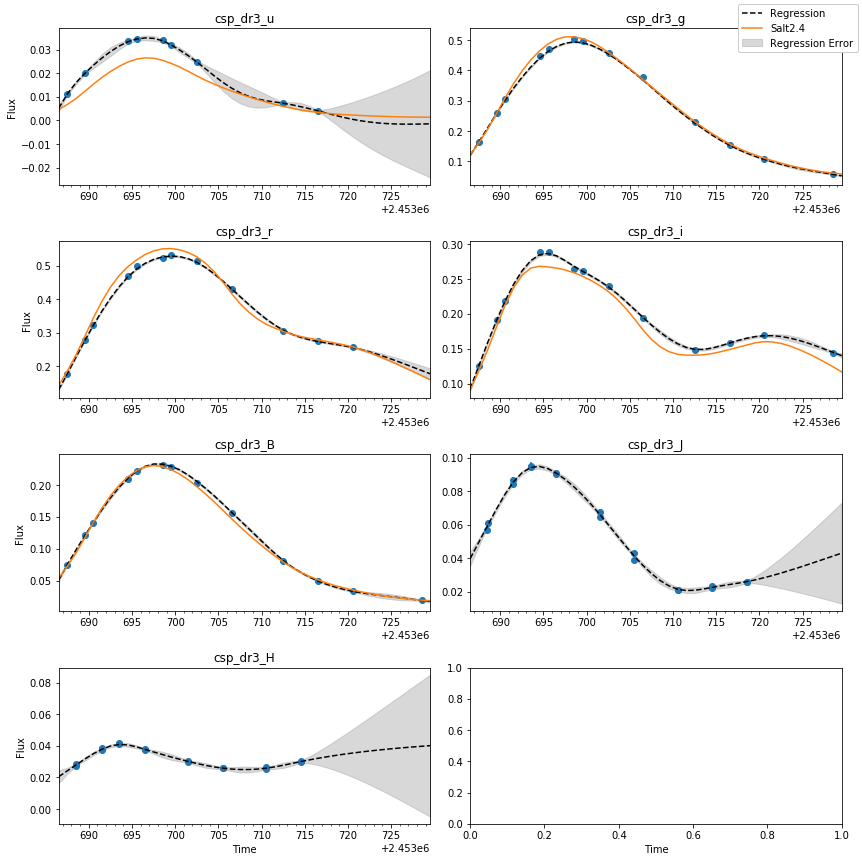

In [4]:
# Pick a CSP target to use in demo plots
demo_id = '2005kc'
demo_data = dr3.get_data_for_id(demo_id)

bands = ['csp_dr3_' + b for b in 'ugriBJH']

# Fit a gaussian regression
gp = lc_regression.fit_gaussian_process(demo_data)
time = np.arange(min(demo_data['time']) - 1, max(demo_data['time']) + 1)
gp_flux, gp_unc = lc_regression.predict_light_curve(gp, bands, time)

# Fit salt2
salt2.set(z=demo_data.meta['z'])
salt2.set(t0=utils.get_csp_t0(demo_id))
fit_result, fitted_model = sncosmo.fit_lc(demo_data, salt2, ['x0', 'x1', 'c'])

# Plot modeled flux
fig, axes = plot_regression(demo_data, time, bands, gp_flux, gp_unc)
plot_sncosmo_flux(time, bands, fitted_model, axes, label='Salt2.4')
scatter_lc(demo_data, bands, axes=axes)

handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), framealpha=1)

plt.tight_layout()


## Deconstructing and Reconstructing Light-Curves <a id='deconstructing'></a>

Now that we can regress light-curves, we see how well we can reconstruct missing photometric measurements. To do this we drop every `n` values from a light-curve, estimate the missing values using either a linear interpolation or a Gaussian regression, and then fit the recovered values using Salt2.


In [5]:
def drop_nth_point(data, n):
    """Drop the nth point in each band
    
    Args:
        data (Table): A table of photometric data with column ``band``
        n      (int): How often to drop an observation
        
    Returns:
        A Table with some data removed
    """
    
    band_tables = []
    for band_data in data.group_by('band').groups:
        indices = (np.arange(len(band_data)) % n) != 0
        band_tables.append(band_data[indices])

    return vstack(band_tables)

def reconstruct_light_curve(data, n):
    """Drop the nth point in each band and then estimate the missing values
    
    The missing values are determined using both a Gaussian regression and a linear
    interpolation.
    
    Args:
        data (Table): A table of photometric data with column ``band``
        n      (int): How often to drop an observation
        
    Returns:
        A Table that is the same as ``data`` but with the added columns: 
          - interp_flux
          - gauss_flux
          - gauss_unc
    """
    
    deconstructed = drop_nth_point(data, n)
    gp = lc_regression.fit_gaussian_process(deconstructed)
    
    band_tables = []
    for band in set(data['band']):
        orig_data = data[data['band'] == band]
        dec_data = deconstructed[deconstructed['band'] == band]
        interp_flux = np.interp(orig_data['time'], dec_data['time'], dec_data['flux'])
        gauss_flux, gauss_unc = lc_regression.predict_band_flux(gp, band, orig_data['time'])
        
        orig_data['interp_flux'] = interp_flux
        orig_data['gauss_flux'] = gauss_flux
        orig_data['gauss_unc'] = gauss_unc
        band_tables.append(orig_data)

    out_table = vstack(band_tables)
    out_table['rec'] = out_table['flux'] != out_table['interp_flux']
    return out_table
    

For demonstration purposes, we choose to drop every third data point. Note that this will result in some values being extrapolated at the end of the observed phase range. The `rec` columns indicate whether a given value was recovered using an interpolation technique (i.e., whether the value was is an `nth` data point).

In [6]:
reconstructed = reconstruct_light_curve(demo_data, 3)
dropped_data = reconstructed[reconstructed['rec']]
kept_data = reconstructed[~reconstructed['rec']]

reconstructed[:10]


time,band,mag,mag_err,zp,zpsys,flux,fluxerr,interp_flux,gauss_flux,gauss_unc,rec
float64,object,float64,float64,float64,str2,float64,float64,float64,float64,float64,bool
2453687.52,csp_dr3_r,16.787999999999997,0.011,14.902,ab,0.17603539536161683,0.0017834804996754773,0.2800270595010636,0.2016537429781522,0.005160883365970881,True
2453689.57,csp_dr3_r,16.284,0.009,14.902,ab,0.2800270595010636,0.0023212300782315806,0.2800270595010636,0.2835076423561276,0.0018906748669848062,False
2453690.54,csp_dr3_r,16.122999999999998,0.008,14.902,ab,0.3247880187635376,0.0023931265612415747,0.3247880187635376,0.32251323810911003,0.001742183018466219,False
2453694.58,csp_dr3_r,15.72,0.009,14.902,ab,0.4707604832565829,0.0039022778560222115,0.46369777128251977,0.46251419841243546,0.0030168842854511073,True
2453695.59,csp_dr3_r,15.658,0.008,14.902,ab,0.4984252094042597,0.003672532662869389,0.4984252094042597,0.48684112093403087,0.0027589916637128804,False
2453698.55,csp_dr3_r,15.605,0.006,14.902,ab,0.5233593651867576,0.0028921907341388524,0.5233593651867576,0.5242499703582837,0.002333194638658704,False
2453699.54,csp_dr3_r,15.586,0.007,14.902,ab,0.5325985748490611,0.003433789909192501,0.5212296164855417,0.5270562371420056,0.002453161829221772,True
2453702.55,csp_dr3_r,15.623,0.006,14.902,ab,0.5147543199312623,0.0028446374967072306,0.5147543199312623,0.5089095939232209,0.002394911343216334,False
2453706.56,csp_dr3_r,15.815,0.009,14.902,ab,0.43132040069941624,0.0035753469298369,0.43132040069941624,0.43393558594937076,0.0031024689868360223,False


In [7]:
# Fit salt2
salt2.set(z=demo_data.meta['z'])
salt2.set(t0=utils.get_csp_t0(demo_id))

_, all_fitted_model = sncosmo.fit_lc(demo_data, salt2, ['x0', 'x1', 'c'])

temp = reconstructed.copy()
temp['flux'] = temp['interp_flux']
_, interp_fitted_model = sncosmo.fit_lc(temp, salt2, ['x0', 'x1', 'c'])

temp = reconstructed.copy()
temp['flux'] = temp['gauss_flux']
_, gauss_fitted_model = sncosmo.fit_lc(temp, salt2, ['x0', 'x1', 'c'])


/opt/anaconda3/envs/lc_regression/lib/python3.8/site-packages/sncosmo/fitting.py:156: RuntimeWarning: Dropping following bands from data: csp_dr3_Y, csp_dr3_H, csp_dr3_J(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_J' [11050, .., 14050] outside spectral range [2030.2, .., 9338.92]
salt2 2.4: bandpass 'csp_dr3_H' [14000, .., 18844] outside spectral range [2030.2, .., 9338.92]


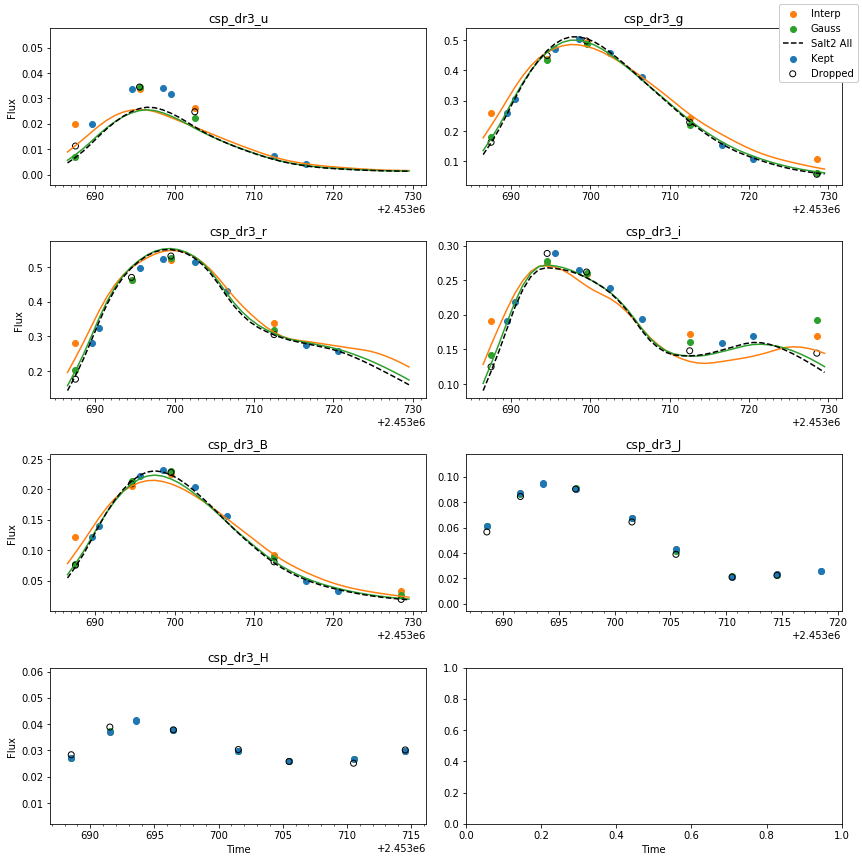

In [8]:
# Plot results using interpolation
fig, axes = scatter_lc(dropped_data, bands, 'interp_flux', label='Interp', color='C1')
plot_sncosmo_flux(time, bands, interp_fitted_model, axes=axes, label='Interp', color='C1')

# Plot results using regression
scatter_lc(dropped_data, bands, 'gauss_flux', axes=axes, label='Gauss', color='C2')
plot_sncosmo_flux(time, bands, gauss_fitted_model, axes, label='Gauss', color='C2')

# Plot results using all the measured data
scatter_lc(kept_data, bands, axes=axes, label='Kept', color='C0')
scatter_lc(dropped_data, bands, axes=axes, label='Dropped', facecolors='none', color='k')
plot_sncosmo_flux(time, bands, all_fitted_model, axes, linestyle='--', color='k', label='Salt2 All')

handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), framealpha=1)

plt.tight_layout()
